# Self-Balancing Scooter Control

![](images/self-balancing-scooter.png)

> A self-balancing scooter [...] is a self-balancing personal transporter consisting of two motorized wheels connected to a pair of articulated pads on which the rider places their feet. The rider controls the speed by leaning forward or backward, and direction of travel by twisting the pads.
> 
> Source: <https://en.wikipedia.org/wiki/Self-balancing_scooter>

### Python Dependencies

In [27]:
import numpy as np
from numpy.linalg import *

from scipy.linalg import *
from scipy.integrate import *
from scipy.signal import *

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Polygon

Step 1 - Scooter Planar Model
================================

### Introduction

We consider a simple model of a self-balancing scooter evolving in the plane. It is mainly made of

  - The frame that contains the two articulated pads; from above, each pad essentially look like a triangle (one vertice in the center of the frame, one vertice at each extremity of the wheel).

  - Two fixed wheels (their orientation with respect to the frame does not change). 
    They are parallel and located at opposite ends of the frame. 
    
Let $(0, e_x, e_y)$ be a direct orthonormal frame of the plane. We denote 

  - $(x, y)$ the coordinates of the wheel axis center in the orthonormal and 
  - $\theta$ the angle of the wheels direction with respect to vector $e_x$ ; with $\theta = 0$ when the front of the scooter faces the right ($e_x$) and $\theta = \pi/2$ when it faces upwards ($e_y$).

  - $\phi_l$ and $\phi_r$ the rotation angles of the left and right wheel respectively ; by convention, when these angles increase, the scooter moves forward.

### Parameter Definition

From now on, we assume that the seat frame length is $\ell = 50 \mbox{ cm}$ and the wheel radius is $r = 12.5 \mbox{ cm}$.

🧩 Define the corresponding Python variables `l` and `r` (express every length in meters, and more generally in the sequel, always use the [international standard of units](https://en.wikipedia.org/wiki/SI_derived_unit)) for numerical values. 

In [28]:
l = 0.5
r = 0.125

### Graphical Representation

🧩 Implement a function `draw_scooter` with arguments `x`, `y` and `theta` that draws a simple geometric model of the wheelchair (with a red frame and black fixed wheels) in the plane (top view) for arbitrary values of $(x, y)$ and $\theta$. Use a green circle marker 50 cm in of the frame to indicate which way is forward.

🗝️ **Hint.** Use the function `plot` of `matplotlib.pyplot`.

In [29]:
def rotate_point(x, y, theta, x_center, y_center):
# Calculate the rotated coordinates
    x_rotated = (x - x_center) * np.cos(theta) - (y - y_center) * np.sin(theta) + x_center
    y_rotated = (x - x_center) * np.sin(theta) + (y - y_center) * np.cos(theta) + y_center
    return (x_rotated, y_rotated)

def draw_hoverboard(x, y, theta) :
  half_side = l/2
  wheel_thickness = 0.05

  up_tr_coord1 = rotate_point(x - half_side/2, y + half_side, theta, x, y)
  up_tr_coord2 = rotate_point(x + half_side/2, y + half_side, theta, x, y)
  down_tr_coord1 = rotate_point(x - half_side/2, y - half_side, theta, x, y)
  down_tr_coord2 = rotate_point(x + half_side/2, y - half_side, theta, x, y)

  # Define the coordinates of the upper triangle vertices
  upper_triangle_coords = [up_tr_coord1, up_tr_coord2, (x, y)]
  lower_triangle_coords = [down_tr_coord1, down_tr_coord2, (x, y)]

  # Create upper triangle
  upper_triangle = Polygon(upper_triangle_coords, closed=True, fill=True, color='blue')  # You can change the color
  lower_triangle = Polygon(lower_triangle_coords, closed=True, fill=True, color='blue')  # You can change the color

  # Add the upper triangle to the axes
  ax.add_patch(upper_triangle)
  ax.add_patch(lower_triangle)


  top_bar_coord1 = rotate_point(x - half_side/2, y + half_side, theta, x, y)
  top_bar_coord2 = rotate_point(x - half_side/2, y + half_side - wheel_thickness, theta, x, y)
  top_bar_coord3 = rotate_point(x + half_side/2, y + half_side - wheel_thickness, theta, x, y)
  top_bar_coord4 = rotate_point(x + half_side/2, y + half_side, theta, x, y)
  bottom_bar_coord1 = rotate_point(x - half_side/2, y - half_side, theta, x, y)
  bottom_bar_coord2 = rotate_point(x - half_side/2, y - half_side + wheel_thickness, theta, x, y)
  bottom_bar_coord3 = rotate_point(x + half_side/2, y - half_side + wheel_thickness, theta, x, y)
  bottom_bar_coord4 = rotate_point(x + half_side/2, y - half_side, theta, x, y)

  top_bar_coords = [top_bar_coord1, top_bar_coord2, top_bar_coord3, top_bar_coord4]
  bottom_bar_coords = [bottom_bar_coord1, bottom_bar_coord2, bottom_bar_coord3, bottom_bar_coord4]

  # Create top black bar
  top_bar = Polygon(top_bar_coords, closed=True, fill=True, color='black')
  bottom_bar = Polygon(bottom_bar_coords, closed=True, fill=True, color='black')

  # Add the top black bar to the axes
  ax.add_patch(top_bar)
  ax.add_patch(bottom_bar)

  # Add circle
  circle_center = (x + 0.5, y)  # Center coordinates (x, y)
  center_rotated = rotate_point(circle_center[0], circle_center[1], theta, x, y)
  radius = 0.03  # Radius of the circle

  circle = Circle(center_rotated, radius, fill=True, color='green')
  ax.add_patch(circle)

🧩 Represent the wheelchair when $(x, y, \theta) = (0, 0, 0), (2, 2, \pi/2), (0, 4, \pi), (-2, 2, 3\pi/2)$.

🗝️ **Hint.** Use the following `draw_arena` function beforehand.

In [30]:
def draw_arena(xmin, xmax, ymin, ymax):
    wh_ratio = (xmax - xmin) / (ymax - ymin)
    figsize = fig_width, fig_height = 16, 16 / wh_ratio
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect(1)
    ax.set_xticks(np.arange(xmin, xmax + 1, 1))
    ax.set_yticks(np.arange(ymin, ymax + 1, 1))
    ax.grid(True)
    return fig, ax

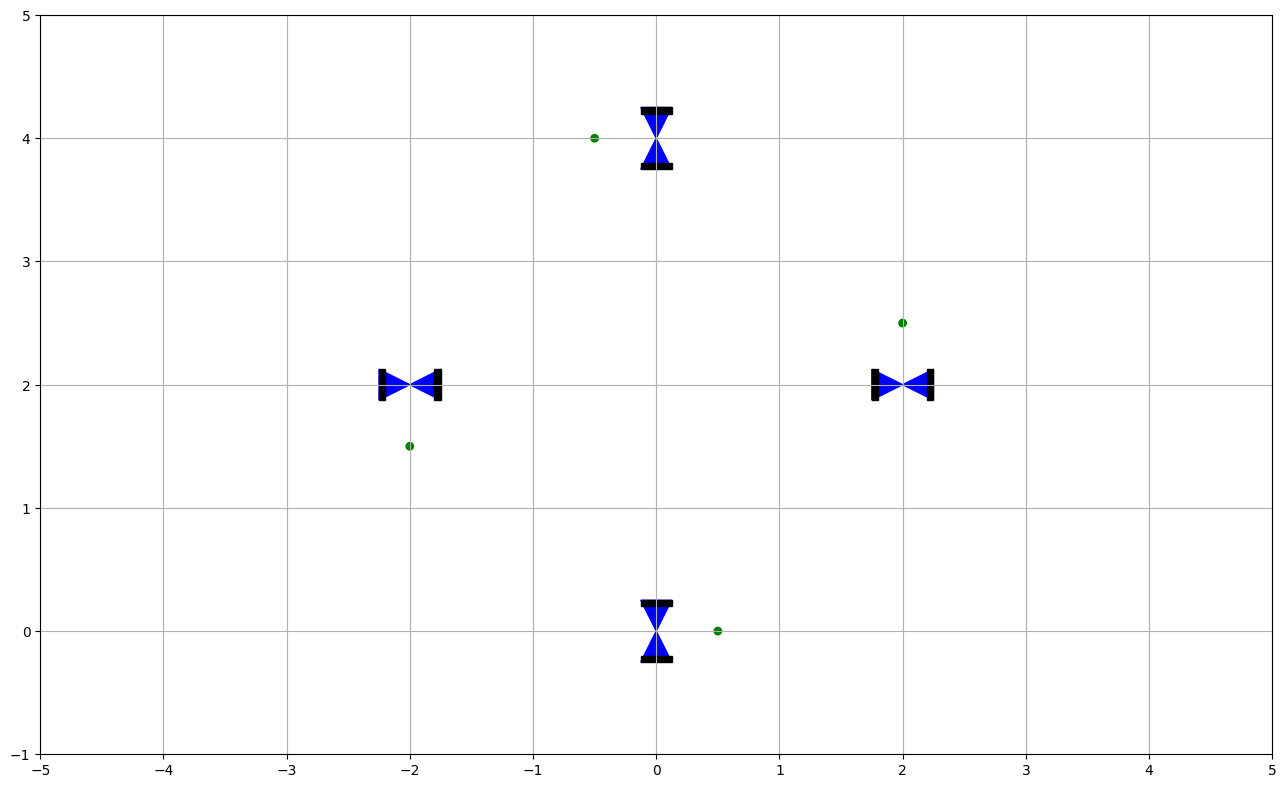

In [31]:
fig, ax = draw_arena(-5, 5, -1, 5)
draw_hoverboard(0, 0, 0)
draw_hoverboard(2, 2, np.pi/2)
draw_hoverboard(0, 4, np.pi)
draw_hoverboard(-2, 2, 3*np.pi/2)
plt.show()

### Kinematic Modeling

We assume that we can control the wheels angular velocities $\omega_l = \dot{\phi}_l$ and $\omega_r = \dot{\phi}_r$ (this is a *kinematic* model of the wheelchair).
We also assume that the wheelchair fixed wheels roll without slipping. 

🧩 Establish the differential equations that relate $\dot{x}$,
$\dot{y}$ and $\dot{\theta}$ with $\omega_l$ and $\omega_r$.

**TODO**

In [32]:
# Differential equations
w_l = 0
w_r = 0
theta = 0

v = r * (w_l + w_r) / 2
theta_point = r * (w_r - w_l) / l

x_point = v * np.cos(theta)
y_point = v * np.sin(theta)

### Analysis

🧩 Show that if $\omega_l$ and $\omega_r$ are continuously differentiable functions of $(x, y, \theta)$ (which includes the case of constant inputs), this system is well-posed.

In [33]:
def omega(t, xytheta):
    omega_l = (1 - 1/4) * np.pi / r
    omega_r = (1 + 1/4) * np.pi / r
    return np.array([omega_l, omega_r])

def fun(t, xytheta):
    x, y, theta = xytheta
    omega_l, omega_r = omega(t, xytheta)

    x_point = r * (omega_l + omega_r) / 2 * np.cos(theta)
    y_point = r * (omega_l + omega_r) / 2 * np.sin(theta)
    theta_point = r * (omega_r - omega_l) / l

    return np.array([x_point, y_point, theta_point])

**TODO**

🧩 Show that if $\omega_l$ and $\omega_r$ are constants, the maximal solution associated to any initial state is global. Is is still true of $\omega_l$ and $\omega_r$ are arbitrary continuously differentiable functions of $(x, y, \theta)$ ?

**TODO**

### Vector Field

In the sequel, `omega` is a function that computes the input vector $\omega := (\omega_l, \omega_r)$ given the time $t$ and $(x, y, \theta)$ (thus, it may depend on the time and/or on the system state if needed). For example:

In [35]:
def omega(t, xytheta):
    omega_l = (1 - l/4) * pi / r
    omega_r = (1 + l/4) * pi / r
    return array([omega_l, omega_r])

🧩 Implement a function `fun(t, xytheta)` that computes $(\dot{x}, \dot{y}, \dot{\theta})$ given the time $t$ and $(x,y,\theta)$ (and implicitly the inputs $\omega$ computed by the function `omega`).

In [36]:
def fun(t, xytheta):
    x, y, theta = xytheta
    omega_l, omega_r = omega(t, xytheta)
    x_point = r * 0.5 * (omega_l + omega_r) * cos(theta)
    y_point = r * 0.5 * (omega_l + omega_r) * sin(theta)
    theta_point = r * (omega_r - omega_l) / l
    return array([x_point, y_point, theta_point])

### Simulation Setup


   

In [37]:
xytheta0 = [0.0, 0.0, 0.0]
time_span = [0, 4]

# Solve the differential equations
solution = solve_ivp(fun=fun, t_span=time_span, y0=xytheta0, dense_output = True)

In [38]:
time = solution["t"]
x = solution["y"][0]
y = solution["y"][1]
theta = solution["y"][2]
sol = solution["sol"]

🧩 Use the simulation results to draw the graphs of $x(t)$, $y(t)$ and $\theta(t)$.

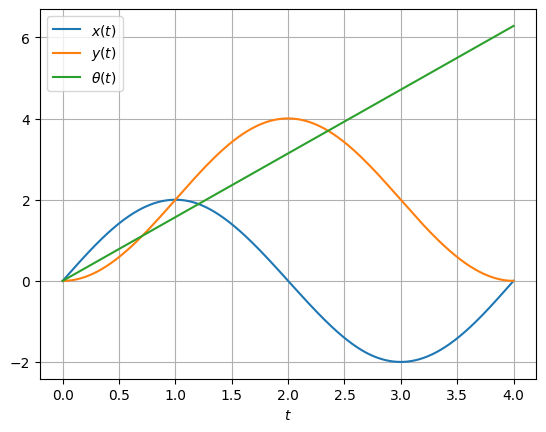

In [42]:
plt.figure()
t = np.linspace(0, 4, 1000)
plt.plot(t, sol(t)[0], "-", label="$x(t)$")
plt.plot(t, sol(t)[1], "-", label="$y(t)$")
plt.plot(t, sol(t)[2], "-", label="$ θ(t)$")
plt.xlabel("$t$")
plt.grid()
plt.legend()

🧩 Use the simulation results to display the robot location every 0.5 second.

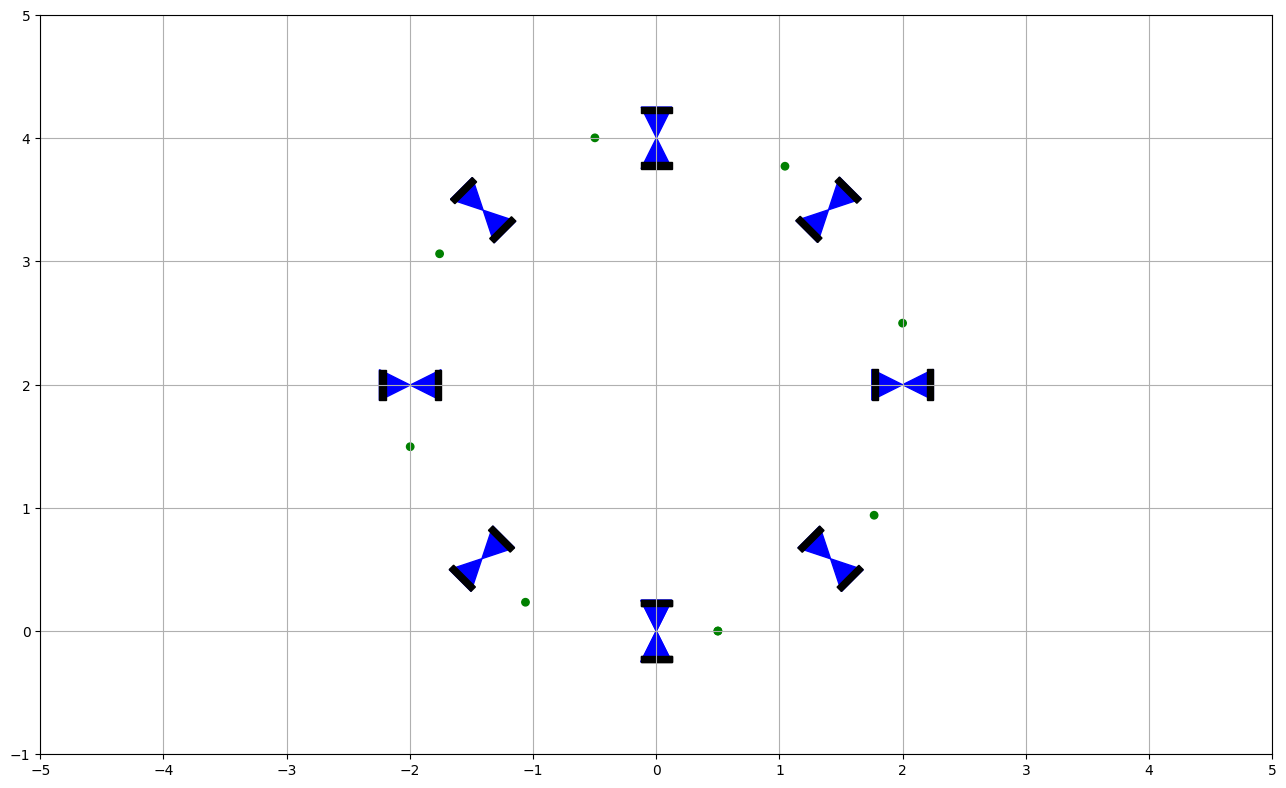

In [43]:
fig, ax = draw_arena(-5, 5, -1, 5)
timespan = [i*0.5 for i in range(9)]
for t in timespan:
    draw_hoverboard(sol(t)[0],sol(t)[1],sol(t)[2])
plt.show()

🧩 What should be the analytical expression of $x(t)$, $y(t)$ and $\theta(t)$? 

**TODO**

🧩 Do you experimental results match the theoretical results ? Draw the curves of the simulation error at time $t$ for $x$, $y$ and $\theta$.

In [5]:
pass

🧩 If needed, adjust the simulation parameters the simulated position error is less than $1\, \mathrm{ mm}$. 

In [6]:
pass